<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

# Определение стоимости автомобилей

## Описание проекта

**Заказчик**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен».

**Задача**

Построить модель для определения рыночной стоимости своего автомобиля. 
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Данные**

Исторические данные: технические характеристики, комплектации и цены автомобилей. 

## Подготовка данных

In [1]:
# Загружаем бибилотеки.  
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.preprocessing import OrdinalEncoder 
import seaborn as sns

In [2]:
set_config(display="text")

In [3]:
# Сохраняем путь к файлу на сервере Практикума.
server_path = '/datasets/autos.csv' 


# Сохраняем путь к файлу на компьютере.
local_path = 'datasets/autos.csv'   

try:                                                   # Пробуем найти данные по сетевому адресу,
    df = pd.read_csv(server_path) 
except:                                                # если не находим по сетевому, ищем по локальному.
    df = pd.read_csv(local_path) 

In [4]:
df.head(10) # Проверяем загрузку данных.

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.info() # Смотрим пропуски и тип данных. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df['NumberOfPictures'].value_counts() # Проверили занчения.

0    354369
Name: NumberOfPictures, dtype: int64

In [7]:
# Закидали списки переменных для удобства анализа и работы. 
number_columns = [
    'Price',
    'RegistrationYear',
    'Power', 
    'Kilometer'
]

category_columns = [
    'VehicleType',
    'Gearbox',
    'Model',
    'RegistrationMonth',
    'FuelType',
    'Brand',
    'NotRepaired',
    'PostalCode'
]

In [8]:
# Убрали лишние колонки
df_needful = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], axis=1)

In [9]:
df_needful.duplicated().sum() # Проверили на дубликаты.

21333

Примечание - Похоже одни и те же автомобили выставляли несколько раз.

In [10]:
df_needful = df_needful.drop_duplicates().reset_index(drop=True) # Удаляем дубликаты. 

In [11]:
df_needful[number_columns].describe() # Проверяем количественные переменные. 

,Price,RegistrationYear,Power,Kilometer
count,333036.000000,333036.000000,333036.000000,333036.000000
mean,4378.277586,2004.192268,109.753225,128305.678665
std,4502.534823,90.288761,194.288179,37900.007564
min,0.000000,1000.000000,0.000000,5000.000000
25%,1000.000000,1999.000000,68.000000,125000.000000
50%,2699.000000,2003.000000,103.000000,150000.000000
75%,6299.250000,2008.000000,140.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


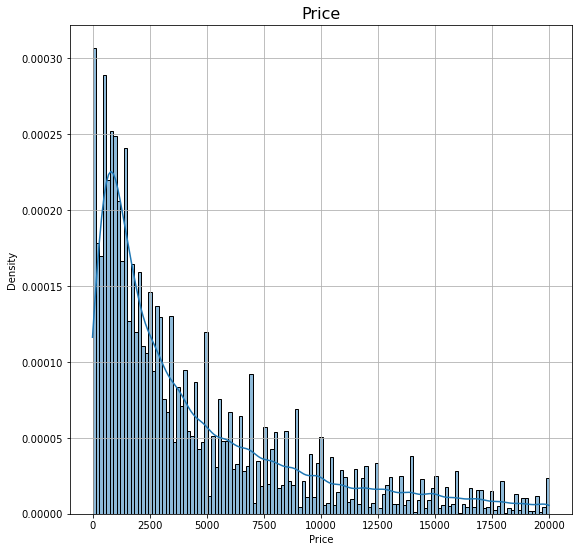

In [12]:
# Постороим гистограмму плотности для Целевого признака.
plt.subplots(figsize=(9, 9))
plt.title('Price', fontsize=16)
sns.histplot(      # гистограммы плотности
        df_needful['Price'], 
        kde=True,
        stat="density", 
        linewidth=1)
plt.grid(True)
plt.show()

In [13]:
df_needful['RegistrationYear'].quantile(0.005) # Проверяем левый квантиль.

1971.0

In [14]:
df_needful['RegistrationYear'].quantile(0.999) # Проверяем правого квантиль.

2018.0

In [15]:
df_needful['Power'].quantile(0.99) # Проверяем левый квантиль.

300.0

In [16]:
df_needful['Power'].quantile(0.1) # Проверяем правого квантиль.

0.0

In [17]:
df_needful = df_needful.query('RegistrationYear >=1970 and RegistrationYear <=2016 and Power <=300') # Фильтруем аномалии. 

In [18]:
df_needful.loc[df_needful['Power'] == 0, 'Power'] = df_needful['Power'].median() # Заполняем нулевые значения. 

In [19]:
df_needful.loc[df_needful['Price'] == 0, 'Price'] = df_needful['Price'].median() # Заполняем нулевые значения. 

In [20]:
df_needful[number_columns].describe() # Проверяем работу с количественными переменными.

,Price,RegistrationYear,Power,Kilometer
count,314683.000000,314683.000000,314683.000000,314683.000000
mean,4438.409876,2002.601361,116.622852,128333.688188
std,4413.387564,6.505707,46.168149,37699.853456
min,1.000000,1970.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,83.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6250.000000,2007.000000,140.000000,150000.000000
max,20000.000000,2016.000000,300.000000,150000.000000


In [21]:
# Выводим уникальные значения категориальных переменных.
for column in category_columns:
    print(column)
    print(df_needful[column].unique())

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox
['manual' 'auto' nan]
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'corsa'
 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'ka' 'a1' 'insignia' 'combo' 'focus' 'tt' 'a6' 'jazz'
 'omega' 'slk' '7er' '80' '147' '100' 'meriva' 'z_reihe' 'sorento' 'v40'
 'ibiza' 'eos' 'touran' 'getz' 'a3' 'almera' 'megane' 'lupo' 'r19' 'caddy'
 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan'
 'mustang' 'sharan' '6_reihe' 'c4' 'panda' 'up' 'i_reihe' 'ceed' '5_reihe'
 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe' '6er' 'modus' 'fox' 'matiz'
 'beetle' 'c1' 'rio' 'touareg' 'logan' 'spider' 'cuore' 's_max' 'a2'
 'galaxy' 'c3' 'vi

In [22]:
# Заполняем NaN значения.
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType']:
    df_needful[column] = df_needful[column].fillna('other')

In [23]:
df_needful['NotRepaired'].value_counts()

no     220539
yes     33129
Name: NotRepaired, dtype: int64

In [24]:
# Заполняем NaN значения.
df_needful['NotRepaired'] = df_needful['NotRepaired'].fillna('no')

In [25]:
# Меняем тип данных.
for column in number_columns:
    df_needful[column] = df_needful[column].astype('int64')

Примечание - LGBMRegressor не захотела работать с float, а после присвоения медиан тип поменялся.

In [26]:
# Проверяем тип и пропуски.
df_needful.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314683 entries, 0 to 333035
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              314683 non-null  int64 
 1   VehicleType        314683 non-null  object
 2   RegistrationYear   314683 non-null  int64 
 3   Gearbox            314683 non-null  object
 4   Power              314683 non-null  int64 
 5   Model              314683 non-null  object
 6   Kilometer          314683 non-null  int64 
 7   RegistrationMonth  314683 non-null  int64 
 8   FuelType           314683 non-null  object
 9   Brand              314683 non-null  object
 10  NotRepaired        314683 non-null  object
 11  PostalCode         314683 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 31.2+ MB


In [27]:
# Убираем лишнее.
df_needful = df_needful.drop(['PostalCode', 'Model', 'RegistrationMonth'], axis=1)

In [28]:
# Вводим новый список категориальных переменных. 
category_columns = [
    'VehicleType',
    'Gearbox',
    'FuelType',
    'Brand',
    'NotRepaired'
]

###### **Анализ данных:**
- DateCrawled, DateCreated, LastSeen – поля с датами, заполняемые автоматически системой, в соответствии с задание эти данные будут генерироваться, когда пользователь будет заполнять анкету на оценку, и даты в базе всегда будут более поздние даты, предлагаю не использовать для моделирования.    
- VehicleType – категориальная переменная, содержит пропуски, заменим на значение 'other', которое также присутствует.
- RegistrationYear – есть аномалии как слева так и справа, ограничил выборку 1970 и 2016 годом, с 2016 все понятно, а вот с нижней границей, в базе встречаются и более старые авто чем 1970, но их очень мало и оценка старых(раритетных автомобилей) – это все же задача другой плоскости.
- Gearbox – категориальная переменная, содержит пропуски, заменим на значение 'other'.
- Power – содержала как аномально высокие значения, так и большое количество 0 значения, 0 заполнил медианным значением, верхний порог 300.
- Model – категориальная переменная, с большим числом значений, пропуски заменил на значение 'other', которое также присутствует. Попробовал на использовать при моделировании большого прироста не дает, решил от нее отказаться, но целесообразно, для различных марок автомобилей (Brand) особенно с широким модельным рядом, создавать свои модели в рамках одной марки, это даст более точный результаты.
- Kilometer – аномалий нет
- RegistrationMonth – оказалось 13 месяцев, есть 0, не стал использовать при моделировании, модели машин привязаны к году. 
- FuelType – категориальная переменная, содержит пропуски, заменим на значение 'other', которое также присутствует.
- Brand – категориальная переменная, нет пропусков, все хорошо.
- NotRepaired – категориальная переменная, пропуски заполнил на no.
- NumberOfPictures – для всех записей 0, предлагаю не использовать для моделирования.
- PostalCode – категориальная переменная, с большим числом значений, предлагаю не использовать для моделирования, возможно сгруппировать пользователей по регионам и уже использовать эту характеристику. 
- Price – есть 0 значения заполнил их медианным значением. 


## Обучение моделей

In [29]:
# Списки для сохранения результатов.
cbr_list = ['CBR']
lgbmr_list = ['LGBMR']
dtr_list = ['DTR']
rfr_list = ['RFR']

### CatBoostRegressor

In [30]:
# Переменные для признаков и целевого признака. 
target = df_needful['Price']
features = df_needful.drop(['Price'] , axis=1)

In [31]:
features_train, features_temp, target_train, target_temp = train_test_split(
    features,
    target, 
    test_size=0.4, 
    random_state=12345,
    shuffle=True
)

In [32]:
# Разбиение на данные для валидацию и тестирование по .5 (.2 по изначальной).
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp,
    target_temp, 
    test_size=0.5, 
    random_state=12345,
    shuffle=True
)

In [33]:
# Проверяем разбиение.
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(188809, 8)
(188809,)
(62937, 8)
(62937,)
(62937, 8)
(62937,)


In [34]:
# Список параметров.
parameters = {'learning_rate': [0.1, 0.2],
             'depth':[8, 12]} 

In [35]:
cbr = CatBoostRegressor(loss_function="RMSE", iterations=150, random_seed=12345)

In [36]:
#Задаем параметры модели и поиска.
cbr_model = GridSearchCV(cbr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) 

In [37]:
%%time
cbr_model.fit(features_train, target_train, cat_features=category_columns, verbose=75) # Обучаем модель.

0:	learn: 3810.4390333	total: 255ms	remaining: 38s
75:	learn: 1589.7567214	total: 8.51s	remaining: 8.29s
149:	learn: 1507.0879322	total: 16.5s	remaining: 0us
CPU times: total: 7.52 s
Wall time: 2min 12s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001954A0F5C10>,
             n_jobs=-1,
             param_grid={'depth': [8, 12], 'learning_rate': [0.1, 0.2]},
             scoring='neg_root_mean_squared_error')

In [38]:
cbr_model.best_estimator_.feature_importances_

array([10.19434723, 32.45117944,  3.10463363, 25.42021571,  9.4128879 ,
        3.50474551, 12.90933941,  3.00265117])

In [39]:
cbr_model.best_estimator_.feature_names_

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Kilometer',
 'FuelType',
 'Brand',
 'NotRepaired']

In [40]:
data = []
data.append(cbr_model.best_estimator_.feature_names_)
data.append(cbr_model.best_estimator_.feature_importances_)
pd.DataFrame(data=data).transpose().sort_values(by=1, ascending=False)

,0,1
1,RegistrationYear,32.451179
3,Power,25.420216
6,Brand,12.909339
0,VehicleType,10.194347
4,Kilometer,9.412888
5,FuelType,3.504746
2,Gearbox,3.104634
7,NotRepaired,3.002651


In [41]:
# Параметры лучшей модели.
cbr_model.best_params_

{'depth': 12, 'learning_rate': 0.2}

In [42]:
%%time
pred_train = cbr_model.best_estimator_.predict(features_train) # Делаем предсказание на тренеровочной выборки.

CPU times: total: 562 ms
Wall time: 290 ms


In [43]:
%%time
pred_valid = cbr_model.best_estimator_.predict(features_valid) # Делаем предсказание на валидационной  выборки.

CPU times: total: 46.9 ms
Wall time: 94.5 ms


In [44]:
# Расчитываем RMSE
cbr_list.append(round(mean_squared_error(target_train, pred_train) ** 0.5, 2))
cbr_list.append(round(mean_squared_error(target_valid, pred_valid) ** 0.5, 2))

In [45]:
cbr_list = cbr_list + [4 * 60 + 40, 0.3 , 0.10]

### LGBMRegressor

In [46]:
# Список параметров.
parameters = {'learning_rate': [0.1, 0.2],
             'max_depth':[8, 12]} 

In [47]:
# Для LGBMRegressor меняем тип категориальных переменных.
for column in category_columns:
    features_train[column] = pd.Series(features_train[column], dtype="category")   

In [48]:
lgbmr = LGBMRegressor(n_estimators=150)

In [49]:
#Задаем параметры модели и поиска.
lgbmr_model = GridSearchCV(lgbmr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) 

In [50]:
%%time
lgbmr_model.fit(features_train, target_train, categorical_feature=category_columns) # Обучаем модель.

C:\Users\moryk\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: total: 3.91 s
Wall time: 6.98 s


GridSearchCV(cv=5, estimator=LGBMRegressor(n_estimators=150), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [8, 12]},
             scoring='neg_root_mean_squared_error')

In [51]:
# Параметры лучшей модели
lgbmr_model.best_params_

{'learning_rate': 0.2, 'max_depth': 12}

In [52]:
%%time
pred_train = lgbmr_model.best_estimator_.predict(features_train) # Делаем предсказание на тренеровочной выборки.

CPU times: total: 1.88 s
Wall time: 179 ms


In [53]:
# Расчитываем RMSE.
lgbmr_list.append(round(mean_squared_error(target_train, pred_train) ** 0.5, 2))

In [54]:
# Для LGBMRegressor меняем тип категориальных переменных.
for column in category_columns:
    features_valid[column] = pd.Series(features_valid[column], dtype="category")

In [55]:
%%time
pred_valid = lgbmr_model.best_estimator_.predict(features_valid) # Делаем предсказание на валидационной  выборки.

CPU times: total: 812 ms
Wall time: 83 ms


In [56]:
# Расчитываем RMSE.
lgbmr_list.append(round(mean_squared_error(target_valid, pred_valid) ** 0.5, 2))

In [57]:
lgbmr_list = lgbmr_list + [2 * 60, 2 , 0.72]

### DecisionTreeRegressor

In [58]:
encoder = OrdinalEncoder()

In [59]:
df_oe = pd.DataFrame(encoder.fit_transform(df_needful), 
                                                      columns=df_needful.columns) 

In [60]:
features_oe = df_oe.drop(['Price'] , axis=1)

In [61]:
features_oe_train, features_oe_temp, target_oe_train, target_oe_temp = train_test_split(
    features_oe,
    target, 
    test_size=0.4, 
    random_state=12345,
    shuffle=True
)

In [62]:
features_oe_valid, features_oe_test, target_oe_valid, target_oe_test = train_test_split(
    features_oe_temp,
    target_oe_temp, 
    test_size=0.5, 
    random_state=12345,
    shuffle=True
)

In [63]:
# Список параметров.
parameters = {'max_depth': [8, 14, 20],
             'max_features':[3, 4, 5]} 

In [64]:
dtr = DecisionTreeRegressor(random_state=12345)

In [65]:
#Задаем параметры модели и поиска.
dtr_model = GridSearchCV(dtr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) 

In [66]:
%%time
dtr_model.fit(features_oe_train, target_oe_train) # Обучаем модель.

CPU times: total: 359 ms
Wall time: 2.45 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [8, 14, 20], 'max_features': [3, 4, 5]},
             scoring='neg_root_mean_squared_error')

In [67]:
dtr_model.best_params_

{'max_depth': 14, 'max_features': 5}

In [68]:
%%time
pred_train = dtr_model.best_estimator_.predict(features_oe_train) # Делаем предсказание на тренеровочной выборки.

CPU times: total: 15.6 ms
Wall time: 23.4 ms


In [69]:
%%time
pred_valid = dtr_model.best_estimator_.predict(features_oe_valid) # Делаем предсказание на валидационной  выборки.

CPU times: total: 0 ns
Wall time: 9.49 ms


In [70]:
# Расчитываем RMSE.
dtr_list.append(round(mean_squared_error(target_oe_train, pred_train) ** 0.5, 2))
dtr_list.append(round(mean_squared_error(target_oe_valid, pred_valid) ** 0.5, 2))

In [71]:
dtr_list = dtr_list + [7, 0.03, 0.03]

### RandomForestRegressor

In [72]:
parameters = { # Список параметров.
    'n_estimators': [100, 200]
}

In [73]:
rfr = RandomForestRegressor(max_depth=14, random_state=12345, max_features=5) #Задаем параметры модели и поиска.

In [74]:
rfr_model = GridSearchCV(rfr, parameters, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1) # Обучаем модель.

In [75]:
%%time
rfr_model.fit(features_oe_train, target_oe_train)

CPU times: total: 12.9 s
Wall time: 1min 12s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=14, max_features=5,
                                             random_state=12345),
             n_jobs=-1, param_grid={'n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [76]:
rfr_model.best_params_

{'n_estimators': 200}

In [77]:
%%time
pred_train = rfr_model.best_estimator_.predict(features_oe_train) # Делаем предсказание на тренеровочной выборки.

CPU times: total: 2.38 s
Wall time: 3.78 s


In [78]:
%%time
pred_valid = rfr_model.predict(features_oe_valid) # Делаем предсказание на валидационной  выборки.

CPU times: total: 672 ms
Wall time: 1.31 s


In [79]:
# Расчитываем RMSE.
rfr_list.append(round(mean_squared_error(target_oe_train, pred_train) ** 0.5, 2))
rfr_list.append(round(mean_squared_error(target_oe_valid, pred_valid) ** 0.5, 2))

In [80]:
rfr_list = rfr_list + [4 * 60, 4, 2]

## Анализ моделей

In [81]:
# Вывод по моделированию 
columns =[
    'model',
    'rmse_train',
    'rmse_valid',
    'wall_time_fit_s',
    'wall_time_pred_tr_s',
    'wall_time_pred_val_s',
]
data = []


data.append(cbr_list)
data.append(lgbmr_list)
data.append(dtr_list)
data.append(rfr_list)

pd.DataFrame(data=data, columns=columns)

,model,rmse_train,rmse_valid,wall_time_fit_s,wall_time_pred_tr_s,wall_time_pred_val_s
0,CBR,1514.15,1664.39,280,0.30,0.10
1,LGBMR,1596.43,1662.26,120,2.00,0.72
2,DTR,1614.09,1953.20,7,0.03,0.03
3,RFR,1479.04,1722.98,240,4.00,2.00


**Анализ данных:**
- Все 4 модели прошли по параметру качества 2500.
- Самая быстрая модель (как по обучению так и по предсказанию),ожидаемо, - это DecisionTreeRegressor, хотя видно что модель  переобучается;
- Самая медленная модель по предсказанию это RandomForestRegressor, очень сильно зависима от количества деревьев в ансамбле при обучении, тоже заметно переобучение, но слабее;
- CatBoostRegressor и  LGBMRegressor дают очень близкие результаты, CatBoostRegressor - делает быстрее предсказания, LGBMRegressor - быстрее обучается (хотя обучение LGBMRegressor проходило не очень стабильно был разброс), CatBoostRegressor примерно одни показатель. Но мне очень понравилась работа CatBoostRegressor с переменными, как категориальными так и числовыми, не требуется лишних вычислений и преобразований, а это тоже занимает время и ресурсы.
- В качестве модели я бы выбрал CatBoostRegressor как золотую середину.

In [82]:
%%time
pred_test = cbr_model.best_estimator_.predict(features_test)

CPU times: total: 78.1 ms
Wall time: 106 ms


In [83]:
mean_squared_error(target_test, pred_test) ** 0.5 # Расчитываем RMSE для CatBoostRegressor на тест данных. 

1674.6525889387367